In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats

sns.set()

## Second-order bias factor comparisons

In [2]:
def n2vplus_alpha_inout(q, w1, w2):
    if w2 >= 1:
        alpha = 1
    elif (w2 < 1) and (w1 < 1):
        alpha = min(1, 1 / q)
    elif (w2 < 1) and (w1 >= 1):
        alpha = 1 / q + (1 - 1 / q) * w2
    return alpha


def n2vplus_cts_alpha_inout(q, w1, w2):
    if w2 >= 1:
        alpha = 1
    else:
        z = w2 if q >= 1 else (1 - w2)
        # Clip the normalized weight from current to next node to
        # fall between zero and one so that the w1 > 1 case recovers
        # the normal node2vec+. Not clipping would also work, where
        # w1 > 1 makes the factor towaards 1 / q more, rather than
        # just a limear interpolation as a function of w2.
        b = np.clip(w1, 0, 1)
        rho = b * z / (1 + (b - 1) * z)
        alpha = rho * abs(1 - 1 / q) + min(1, 1/ q)
    return alpha


def map_alpha(q, w1, w2, alpha_func):
    alpha = np.zeros(w1.shape)
    for i, _ in np.ndenumerate(w1):
        alpha[i] = alpha_func(q, w1[i], w2[i])
    return alpha

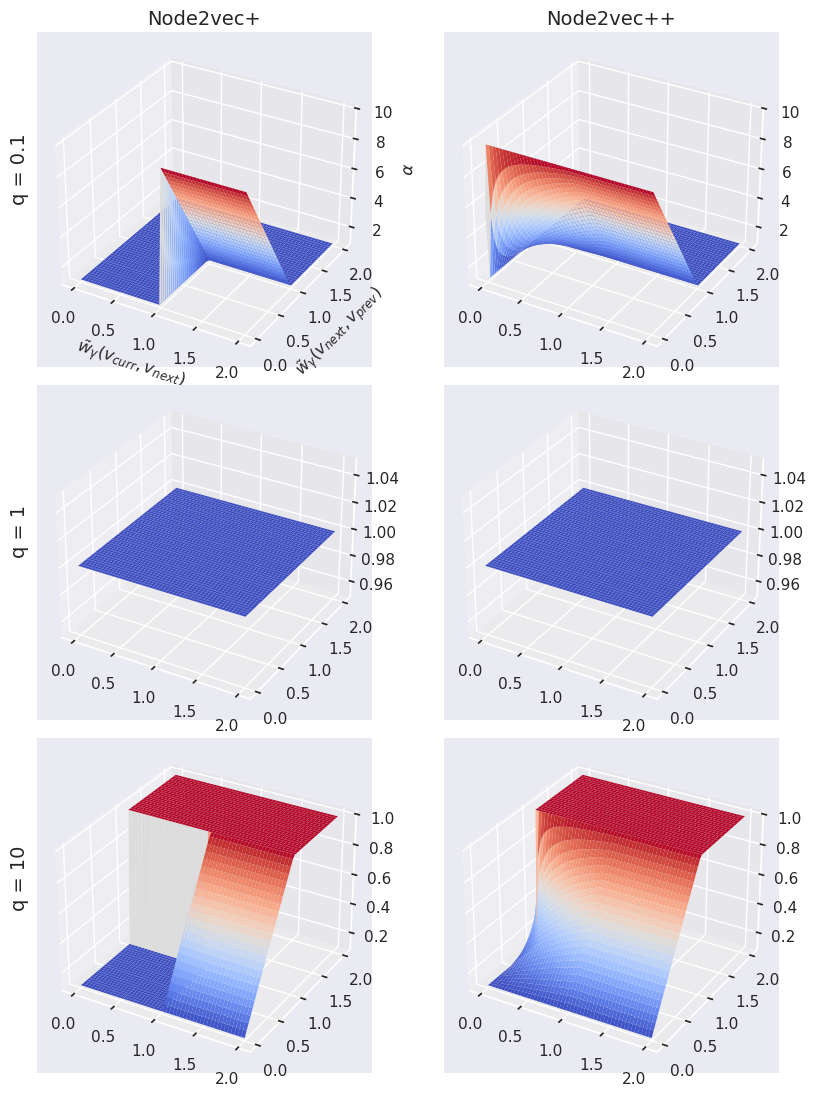

In [3]:
qs = [0.1, 1, 10]
alpha_funcs = [n2vplus_alpha_inout, n2vplus_cts_alpha_inout]
names = ["Node2vec+", "Node2vec++"]

w1 = np.linspace(1e-12, 2)
w2 = np.linspace(1e-12, 2)
w1, w2 = np.meshgrid(w1, w2)

fig, axes = plt.subplots(len(qs), 2, subplot_kw={"projection": "3d"}, figsize=(9, 11))
for i, (sub_axes, q) in enumerate(zip(axes, qs)):
    for j, (ax, func, name) in enumerate(zip(sub_axes, alpha_funcs, names)):
        ax.plot_surface(w1, w2, map_alpha(q, w1, w2, func), cmap="coolwarm", linewidth=0)
        
        if i == j == 0:
            ax.set_xlabel(r"$\tilde{w}_{\gamma}(v_{curr}, v_{next})$", fontsize=12)
            ax.set_ylabel(r"$\tilde{w}_{\gamma}(v_{next}, v_{prev})$", fontsize=12)
            ax.set_zlabel(r"$\alpha$", fontsize=12)
    
        if i == 0:
            ax.set_title(name, fontsize=14)
            
        if j == 0:
            ax.text2D(-0.08, 0.5, f"{q = }", transform=ax.transAxes, rotation=90, fontsize=14)

plt.tight_layout()
# plt.savefig("figsupp_n2vplusplus_alpha.png", dpi=300) # uncomment to save

plt.show()

## Gene classification performance analysis

In [4]:
# load results for study bias holdout
result_df = pd.concat([
    pd.read_csv('../result/gene_classification_n2vplus.csv'),
    pd.read_csv('../result/gene_classification_n2vplusplus.csv'),
]).reset_index()
optim_idx_ary = result_df.groupby(['Network', 'Method', 'Task'])['Validation score'].agg('idxmax').values
result_df = result_df.iloc[optim_idx_ary]

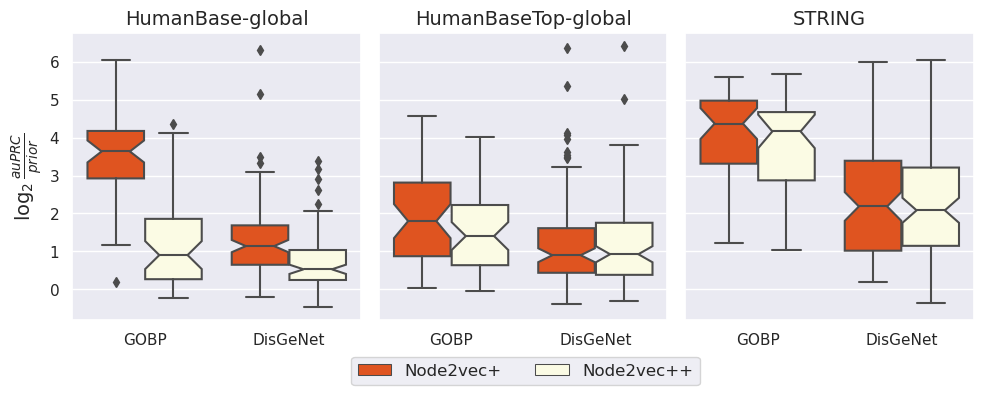

In [5]:
network_list = ['HumanBase-global', 'HumanBaseTop-global', 'STRING']
dataset_list = ['GOBP', 'DisGeNet']
method_list = ['Node2vec+', 'Node2vec++']
color_dict = {"Node2vec+": 'orangered', "Node2vec++": 'lightyellow'}

fig, axes = plt.subplots(1, 3, figsize=(10, 4), sharex=True, sharey='row')
for network, group in result_df.groupby('Network'):
    network_idx = network_list.index(network)
    ax = axes[network_idx]

    sns.boxplot(data=group, order=dataset_list, x='Dataset',
                y='Testing score', palette=color_dict, hue='Method',
                hue_order=method_list, notch=True, ax=ax)

    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.get_legend().remove()
    ax.set_title(network, fontsize=14)
axes[0].set_ylabel(r"$\log_2 \frac{auPRC}{prior}$", fontsize=14)
plt.tight_layout()

plt.subplots_adjust(bottom=0.18)
axes[1].legend(bbox_to_anchor=(1.14, -0.1), ncol=4, fontsize=12)
# plt.savefig("figsupp_n2vplusplus_bio_nc_eval.png", dpi=300) # uncomment to save

plt.show()